In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = '/content/drive/MyDrive/DS102 - Machine Learning/Hotel/data/'

# Load dữ liệu

In [ ]:
X_train = pd.read_csv(DATA_PATH + 'X_train.csv')
X_dev = pd.read_csv(DATA_PATH + 'X_dev.csv')
X_test = pd.read_csv(DATA_PATH + 'X_test.csv')

y_train = pd.read_csv(DATA_PATH + 'y_train.csv')
y_dev = pd.read_csv(DATA_PATH + 'y_dev.csv')
y_test = pd.read_csv(DATA_PATH + 'y_test.csv')

In [ ]:
X_train.head()

,lead_time,market_segment,distribution_channel,assigned_room_type,deposit_type,customer_type,required_car_parking_spaces,total_of_special_requests,has_company,has_agent,hotel_type,previous_cancellations_group,previous_bookings_not_canceled_group,booking_changes_group,days_in_waiting_list_group,total_guests,total_stays,is_different_room,country_group
0,80,Direct,Direct,A,No Deposit,Group,1,0,0,1,City,0,0,0,no_wait,2,3,0,GBR
1,128,Online TA,TA/TO,A,No Deposit,Transient-Party,0,1,0,1,Resort,0,0,0,no_wait,1,7,0,IRL
2,12,Groups,TA/TO,A,No Deposit,Transient-Party,0,0,0,1,City,0,0,0,no_wait,2,3,0,PRT
3,168,Online TA,TA/TO,A,No Deposit,Transient,0,1,0,1,City,0,0,0,no_wait,2,7,0,GBR
4,292,Offline TA/TO,TA/TO,D,No Deposit,Transient-Party,0,0,0,1,Resort,0,0,1-2,no_wait,1,2,1,FRA


# Biến đổi và mã hóa dữ liệu

In [ ]:
log_cols = ['lead_time']
ohe_cols = ['market_segment', 'distribution_channel',
            'assigned_room_type', 'customer_type', 'hotel_type',
            'country_group']
ordinal_cols = [
    'previous_cancellations_group',
    'previous_bookings_not_canceled_group',
    'booking_changes_group',
    'days_in_waiting_list_group',
    'deposit_type'
]

ordinal_categories = [
    ['0', '1-5', '>5'],                 # previous_cancellations_group
    ['0', '1-5', '>5'],                 # previous_bookings_not_canceled_group
    ['0', '1-2', '>2'],                 # booking_changes_group
    ['no_wait', 'short', 'medium', 'long', 'very_long'], #days_in_waiting_list_group
    ['No Deposit', 'Refundable', 'Non Refund'] # không đặt cọc, có hoàn tiền , ko hoàn tiền
]

In [ ]:
class LogTransformer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return np.log1p(X)

  def get_feature_names_out(self, input_features=None):
    return np.array([f'log_{feature}' for feature in input_features])


ohe_transformer = OneHotEncoder(
    drop='first',
    handle_unknown='ignore',
    sparse_output=False
)

ord_transformer = OrdinalEncoder(
    categories=ordinal_categories,
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('log', LogTransformer(), log_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('ord', ord_transformer, ordinal_cols)
    ],
    remainder='passthrough'
)

# Độ đo và hàm đánh giá mô hình

In [ ]:
# Đánh giá mô hình
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve,
    confusion_matrix,
    classification_report
)

In [ ]:
def evaluations(y_true, y_pred, y_proba, model_name, dataset):

  print("="*50)
  print(f'Model {model_name}, đánh giá trên tập {dataset}:')
  print("Accuracy :", accuracy_score(y_true, y_pred))
  print("Precision:", precision_score(y_true, y_pred))
  print("Recall   :", recall_score(y_true, y_pred))
  print("F1-score :", f1_score(y_true, y_pred))
  print("ROC-AUC  :", roc_auc_score(y_true, y_proba))
  print("Confusion matrix:")
  print(confusion_matrix(y_true, y_pred))
  print(classification_report(y_true, y_pred))

In [ ]:
def plot_evaluations(y_true, y_pred, y_proba, model_name, dataset):

  fig, axes = plt.subplots(2,2, figsize=(15,8))
  axes = axes.flatten()

  # confusion matrix
  conf_matrix = confusion_matrix(y_true, y_pred)
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
  axes[0].set_title(f'Confusion Matrix - {model_name}, {dataset}')
  axes[0].set_xlabel('Predicted')
  axes[0].set_ylabel('Actual')

  # precision - recall curve
  precision, recall, threshold = precision_recall_curve(y_true, y_proba)
  average_precison = average_precision_score(y_true, y_proba)
  axes[1].plot(recall, precision, linewidth=2, zorder=3)
  axes[1].set_title(f'Precision-Recall Curve - {model_name}, {dataset}\nAverage precision score: {average_precison:.4f}')
  axes[1].set_xlabel('Recall cho lớp Hủy')
  axes[1].set_ylabel('Precision cho lớp Hủy')
  axes[1].grid(True, alpha=0.5, zorder=0)

  # threshold - recall
  thesholds = np.linspace(0,1,100)
  recalls = [
      recall_score(y_true, (y_proba > threshold).astype(int))
      for threshold in thesholds
  ]
  axes[2].plot(thesholds, recalls, linewidth=2, zorder=3)
  axes[2].set_title(f'Threshold - Recall - {model_name}, {dataset}')
  axes[2].set_xlabel('Threshold')
  axes[2].set_ylabel('Recall cho lớp Hủy')
  axes[2].grid(True, alpha=0.5, zorder=0)

  # roc curve
  fpr, tpr, thresholds = roc_curve(y_true, y_proba)
  auc = roc_auc_score(y_true, y_proba)

  axes[3].plot(fpr, tpr, linewidth=2, zorder=3)
  axes[3].plot([0,1], [0,1], 'k--', zorder=1)
  axes[3].set_title(f'ROC Curve - {model_name}, {dataset}\nAUC: {auc:.4f}')
  axes[3].grid(True, alpha=0.5, zorder=0)
  axes[3].set_xlabel('False Positive Rate')
  axes[3].set_ylabel('True Positive Rate')

  plt.tight_layout()
  plt.show()

# Mô hình XGBoost

In [ ]:
from xgboost import XGBClassifier

## Tham số mặc định

### Huấn luyện mô hình

In [ ]:
model_xgb = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBClassifier(random_state=42))
])

In [ ]:
model_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log', LogTransformer(),
                                                  ['lead_time']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['market_segment',
                                                   'distribution_channel',
                                                   'assigned_room_type',
                                                   'customer_type',
                                                   'hotel_type',
                                                   'country_group']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['0...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

### Đánh giá mô hình trên tập dev

In [ ]:
y_dev_pred_xgb = model_xgb.predict(X_dev)
y_dev_proba_xgb = model_xgb.predict_proba(X_dev)[:, 1]
evaluations(y_dev, y_dev_pred_xgb, y_dev_proba_xgb, 'XGBoost', 'dev')

Model XGBoost, đánh giá trên tập dev:
Accuracy : 0.8570614709736227
Precision: 0.8370065789473684
Recall   : 0.7702436809444528
F1-score : 0.8022385118625365
ROC-AUC  : 0.9344512659267005
Confusion matrix:
[[9955  991]
 [1518 5089]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     10946
           1       0.84      0.77      0.80      6607

    accuracy                           0.86     17553
   macro avg       0.85      0.84      0.85     17553
weighted avg       0.86      0.86      0.86     17553



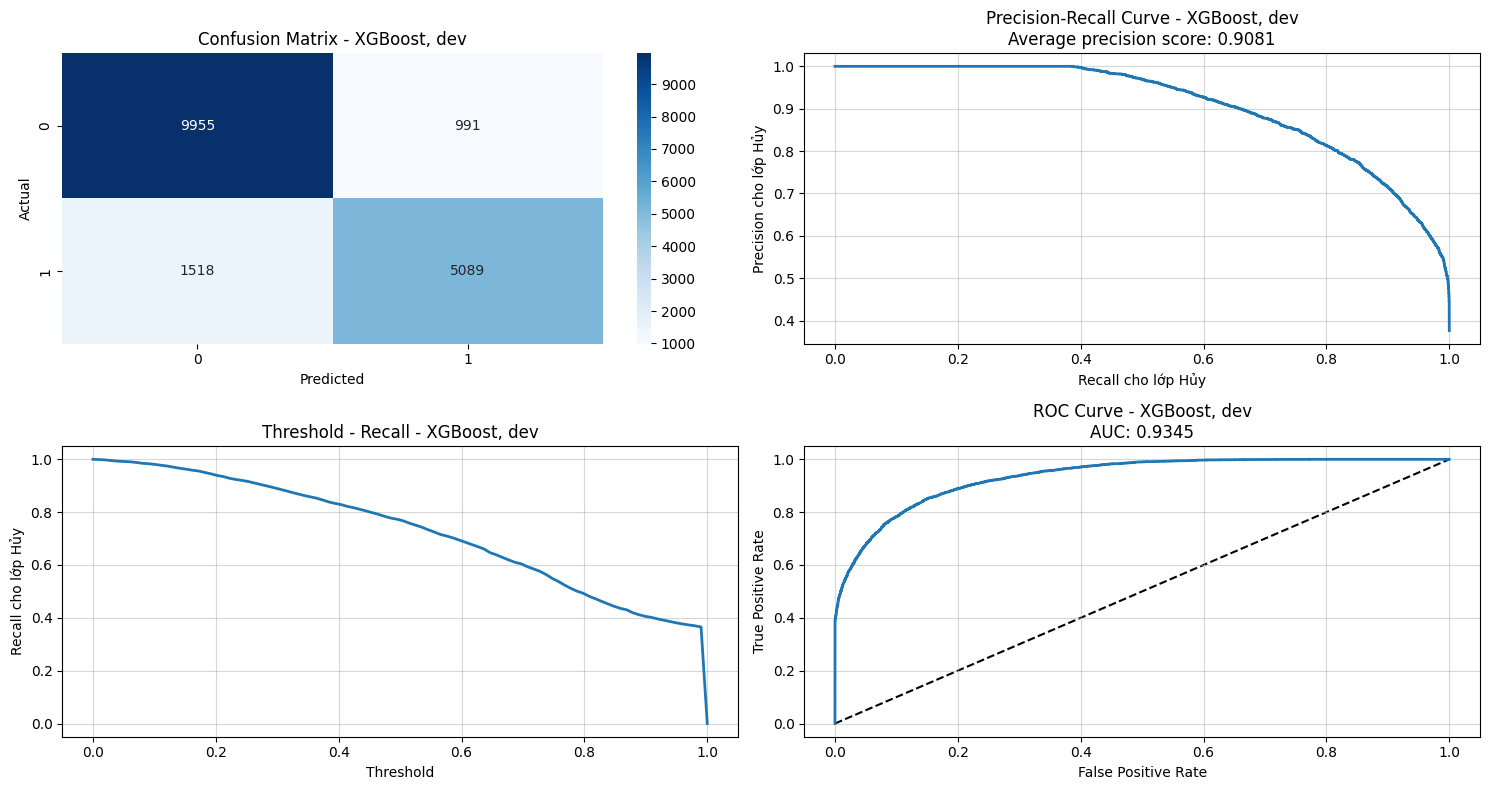

In [ ]:
plot_evaluations(y_dev, y_dev_pred_xgb, y_dev_proba_xgb, 'XGBoost', 'dev')

Mô hình XGBoost cho kết quả trường hợp dự đoán đúng tốt, cụ thể số trường hợp dự đoán không hủy và đúng là 9955 trường hợp, dự đoán hủy và thực tế hủy là 5089 trường hợp. Tuy nhiên, dự đoán không hủy nhưng thực tế hủy cao hơn nhiều trường hợp dự đoán hủy nhưng không hủy (1518 > 991) và precision > recall (0.837 > 0.77). Vì mục tiêu bài toán dự đoán khả năng hủy phòng nên ưu tiên recall (dự đoán nhầm hủy nhưng không hủy) hơn. Do đó, mô hình XGBoost cần tinh chỉnh để phù hợp với mục tiêu bài toán.

## Tinh chỉnh

### Thuật toán GridSearchCV

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint

In [ ]:
count = y_train.value_counts()
ratio = count[0] / count[1]

In [ ]:
parameters_grid = {
    "model__n_estimators" : [100, 200],
    "model__learning_rate" : [0.05, 0.1],
    "model__colsample_bytree" : [0.6, 0.8],
    "model__max_depth" : [3, 5, 7],
    "model__subsample" : [0.6, 0.8],
    "model__scale_pos_weight": [1, ratio]
}

grid_search = GridSearchCV(estimator=model_xgb,
    param_grid=parameters_grid,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
    )

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('log',
                                                                         LogTransformer(),
                                                                         ['lead_time']),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['market_segment',
                                                                          'distribution_channel',
                                                                          'assigned_room_type',
                                                                          '...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.6, 0.8],
                         'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [100, 200],
                         'model__scale_pos_weight': [1,
                                                     np.float64(1.6904582033174578)],
                         'model__subsample': [0.6, 0.8]},
             scoring='f1')

In [ ]:
best_grid = grid_search.best_estimator_
best_grid

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log', LogTransformer(),
                                                  ['lead_time']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['market_segment',
                                                   'distribution_channel',
                                                   'assigned_room_type',
                                                   'customer_type',
                                                   'hotel_type',
                                                   'country_group']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['0...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
print(grid_search.best_estimator_.get_params()["model__scale_pos_weight"])

1.6904582033174578


In [ ]:
y_pred_grid = best_grid.predict(X_dev)
y_proba_grid = best_grid.predict_proba(X_dev)[:, 1]

In [ ]:
evaluations(y_dev, y_pred_grid, y_proba_grid, 'GridSearch', 'dev')

Model GridSearch, đánh giá trên tập dev:
Accuracy : 0.8494844186179
Precision: 0.7753089848632134
Recall   : 0.8450128651430301
F1-score : 0.8086616454229433
ROC-AUC  : 0.9350547555011655
Confusion matrix:
[[9328 1618]
 [1024 5583]]
              precision    recall  f1-score   support

           0       0.90      0.85      0.88     10946
           1       0.78      0.85      0.81      6607

    accuracy                           0.85     17553
   macro avg       0.84      0.85      0.84     17553
weighted avg       0.85      0.85      0.85     17553



* Nhận xét:
    - Mô hình XGBoost sau khi tinh chỉnh bằng thuật toán GridSearchCV với siêu tham số chỉ định cho kết quả cải thiện đáng kể các chỉ số đánh giá so với mô hình XGBoost tham số mặc định. Đánh giá trên tập dev với mô hình tinh chỉnh bằng GridSearchCV, chỉ số ROC-AUC và F1-score tăng không đáng kể (~0.001 cho ROC_AUC và ~0.006 cho F1-score). Tuy nhiên chỉ số recall tăng đáng kể từ 0.77 lên 0.845 và chỉ số precision giảm từ 0.837 xuống 0.775 cho thấy mô hình XGBoost khi tinh chỉnh bằng thuật toán GridSearchCV với tham số chỉ định đã có hiệu suất tối ưu hơn trong không gian tham số được xét và đạt được mục tiêu ưu tiên F1-Score và cải thiện recall cho bài toán.

### Thuật toán RandomizedSearchCV

In [ ]:
parameters_rand = {
    "model__n_estimators" : randint(100, 500),
    "model__max_depth" : randint(3, 10),
    "model__learning_rate" : [0.01, 0.05, 0.1],
    "model__colsample_bytree" : [0.6, 0.8],
    "model__scale_pos_weight": [1, ratio]
}

random_search = RandomizedSearchCV(estimator=model_xgb,
    param_distributions=parameters_rand,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_iter=20,
    n_jobs=-1
)

In [ ]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('log',
                                                                               LogTransformer(),
                                                                               ['lead_time']),
                                                                              ('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['market_segment',
                                                                                'distribution_channel',
                                                                                'assigned_room_t...
                   param_distributions={'model__colsample_bytree': [0.6, 0.8],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1],
                                        'model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x784f49c448c0>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x784f49c44b00>,
                                        'model__scale_pos_weight': [1,
                                                                    np.float64(1.6904582033174578)]},
                   scoring='f1')

In [ ]:
best_rand = random_search.best_estimator_
best_rand

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log', LogTransformer(),
                                                  ['lead_time']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['market_segment',
                                                   'distribution_channel',
                                                   'assigned_room_type',
                                                   'customer_type',
                                                   'hotel_type',
                                                   'country_group']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['0...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=449, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
print(random_search.best_estimator_.get_params()["model__scale_pos_weight"])

1.6904582033174578


In [ ]:
y_dev_pred_rd = best_rand.predict(X_dev)
y_dev_proba_rd = best_rand.predict_proba(X_dev)[:, 1]

In [ ]:
evaluations(y_dev, y_dev_pred_rd, y_dev_proba_rd, 'RandomizedSearchCV', 'dev')

Model RandomizedSearchCV, đánh giá trên tập dev:
Accuracy : 0.8575742038397994
Precision: 0.7902473498233216
Recall   : 0.8462237021341001
F1-score : 0.8172781757053063
ROC-AUC  : 0.9391857923223741
Confusion matrix:
[[9462 1484]
 [1016 5591]]
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     10946
           1       0.79      0.85      0.82      6607

    accuracy                           0.86     17553
   macro avg       0.85      0.86      0.85     17553
weighted avg       0.86      0.86      0.86     17553



* Nhận xét:
    - Mô hình XGBoost sau khi tinh chỉnh bằng thuật toán RandomizedSearchCV với tham số chỉ định cho kết quả cải thiện đáng kể các chỉ số đánh giá so với mô hình XGBoost tham số mặc định. Đánh giá trên tập dev với mô hình được tinh chỉnh cho thấy F1-score tăng 0.015 và ROC_AUC tăng nhẹ 0.005. Tuy nhiên chỉ số recall tăng đáng kể từ 0.77 lên 0.846 và FN ở ma trận nhầm lẫn giảm 502 trường hợp dự đoán bỏ sót khách hủy cho thấy mô hình tinh chỉnh bằng thuật toán RandomizedSearchCV đã tối ưu hơn mô hình XGBoost với tham số mặc định trong không gian tham số được xét.
    - Giữa 2 thuật toán tinh chỉnh vì mục tiêu dự đoán khả năng hủy phòng nên kết quả mô hình tinh chỉnh bằng RandomizeSearchCV cho kết quả tối ưu hiệu suất hơn thuật toán GridSearchCV (mặc dù recall gần như tương đương nhưng F1-score và ROC-AUC của RandomizedSearchCV vẫn chênh hơn và chỉ số FN và FP trong ma trận nhầm lẫn được cải thiện hơn GridSearchCV).

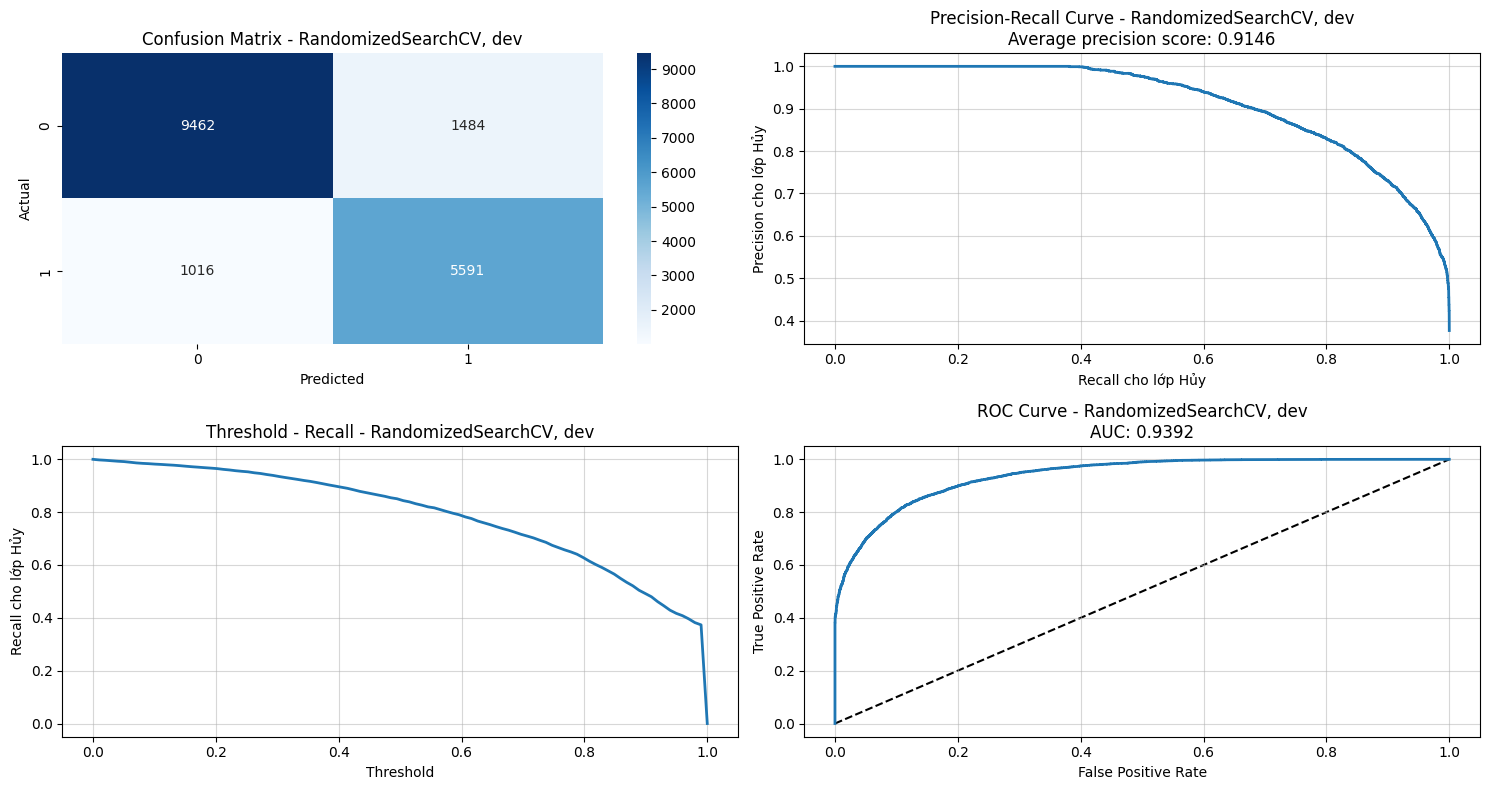

In [ ]:
plot_evaluations(y_dev, y_dev_pred_rd, y_dev_proba_rd, 'RandomizedSearchCV', 'dev')

Dựa vào đường cong Threshold-Recall, cho thấy:
- threshold < 0.2 -> recall cao (> 0.9) -> precision sẽ giảm .(dựa vào Precision-Recall Curve)
- 0.2 <= threshold < 0.6 -> recall vẫn cao (> 0.6) và precision bắt đầu giảm nhưng vẫn ở mức chấp nhận được.
- threshold > 0.6 -> recall bắt đầu giảm trong khi precision không có sự cải thiện tương ứng với recall. Điều này khiến cho F1-score giảm do mất cân bằng giữa recall và precision.
Do đó, vì mục tiêu là tối ưu F1-Score nhưng ưu tiên recall hơn precision nên chọn threshold trong khoảng 0.2 đến 0.6 để duy trì độ chính xác dự đoán. --> dùng ngưỡng 0.3 để thử đánh giá

In [ ]:
threshold = 0.3
y_dev_pred_rd = (y_dev_proba_rd > threshold).astype(int)

In [ ]:
evaluations(y_dev, y_dev_pred_rd, y_dev_proba_rd, 'RandomizedSearchCV- Ngưỡng 0.3', 'dev')

Model RandomizedSearchCV- Ngưỡng 0.3, đánh giá trên tập dev:
Accuracy : 0.8069275907252321
Precision: 0.6758085664335665
Recall   : 0.9361283487210534
F1-score : 0.7849482835205279
ROC-AUC  : 0.9391857923223741
Confusion matrix:
[[7979 2967]
 [ 422 6185]]
              precision    recall  f1-score   support

           0       0.95      0.73      0.82     10946
           1       0.68      0.94      0.78      6607

    accuracy                           0.81     17553
   macro avg       0.81      0.83      0.80     17553
weighted avg       0.85      0.81      0.81     17553



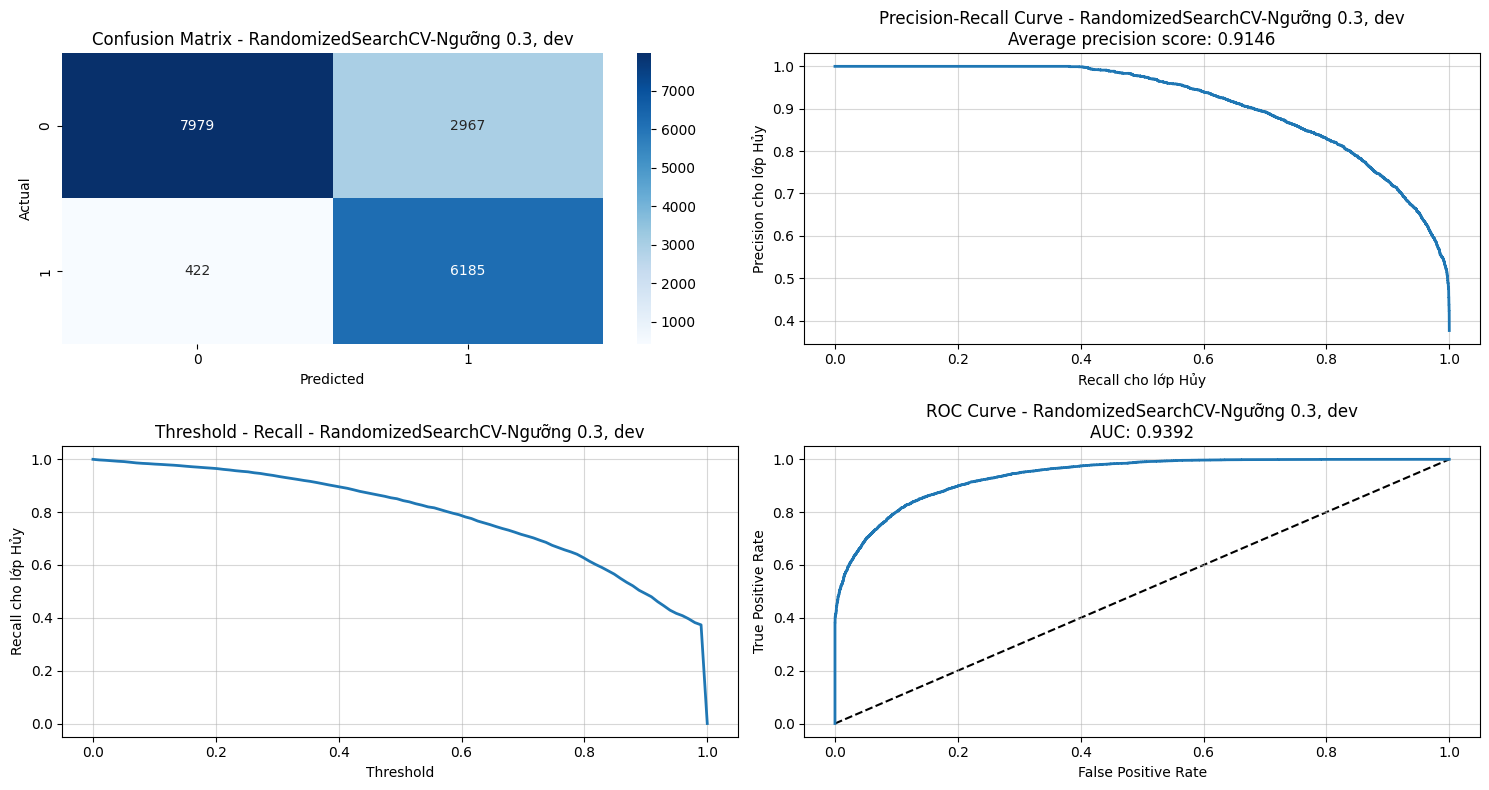

In [ ]:
plot_evaluations(y_dev, y_dev_pred_rd, y_dev_proba_rd, 'RandomizedSearchCV-Ngưỡng 0.3', 'dev')

Mặc dù chỉ số Recall tăng đáng kể nhưng chỉ số F1-Score lại giảm rõ rệt cho thấy mô hình với ngưỡng 0.3 làm mất cân bằng giữa recall và precision. Vì vây, vẫn chọn ngưỡng mặc định 0.5

# Giải thích mô hình

## Importance Feature

In [ ]:
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['log__log_lead_time', 'ohe__market_segment_Complementary',
       'ohe__market_segment_Corporate', 'ohe__market_segment_Direct',
       'ohe__market_segment_Groups', 'ohe__market_segment_Offline TA/TO',
       'ohe__market_segment_Online TA',
       'ohe__distribution_channel_Direct',
       'ohe__distribution_channel_GDS', 'ohe__distribution_channel_TA/TO',
       'ohe__distribution_channel_Undefined', 'ohe__assigned_room_type_B',
       'ohe__assigned_room_type_C', 'ohe__assigned_room_type_D',
       'ohe__assigned_room_type_E', 'ohe__assigned_room_type_F',
       'ohe__assigned_room_type_G', 'ohe__assigned_room_type_H',
       'ohe__assigned_room_type_I', 'ohe__assigned_room_type_K',
       'ohe__assigned_room_type_L', 'ohe__customer_type_Group',
       'ohe__customer_type_Transient',
       'ohe__customer_type_Transient-Party', 'ohe__hotel_type_Resort',
       'ohe__country_group_BEL', 'ohe__country_group_BRA',
       'ohe__country_group_CHE', 'ohe__country_group_CN',
      

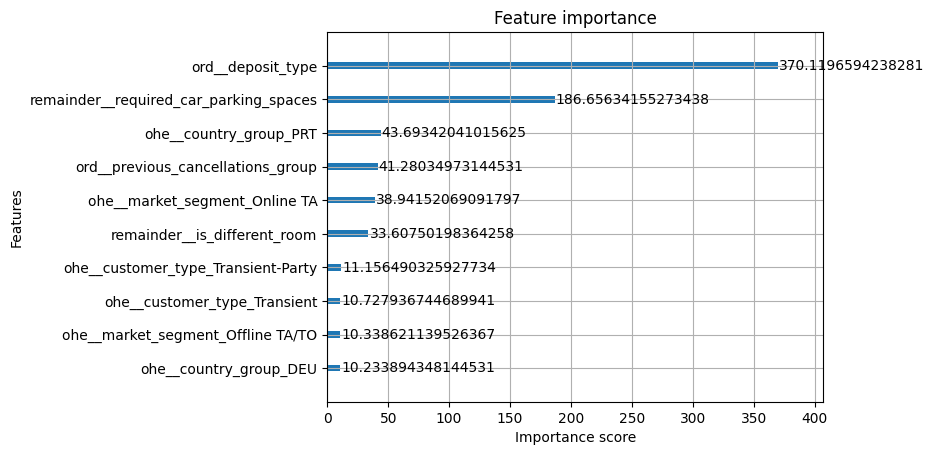

In [ ]:
from xgboost import plot_importance

booster = best_rand.named_steps["model"].get_booster()
booster.feature_names = feature_names.tolist()
plot_importance(best_rand.named_steps["model"], max_num_features=10, importance_type="gain")
plt.show()


*   importance score càng lớn -> đặc trưng đó càng có ảnh hưởng
*   Dựa vào biểu đồ cho thấy các đặc trưng ord_deposit_type, remainder_required_car_parking_spaces, ohe_country_group_PRT, ord_previous_cancellations_group,
ohe_market_segment_online_TA và remainder_is_different_room  có ảnh hưởng đáng kể đến quyết định của mô hình dự đoán khả năng hủy hay không. Tuy nhiên deposit_type là đặc trưng quan trọng nhất và có ảnh hưởng mạnh nhất.

## SHAP

In [ ]:
import shap
X_dev_trans = preprocessor.transform(X_dev)

In [ ]:
explainer = shap.TreeExplainer(best_rand.named_steps["model"])
shap_values = explainer(X_dev_trans)
shap_values.feature_names = feature_names.tolist()

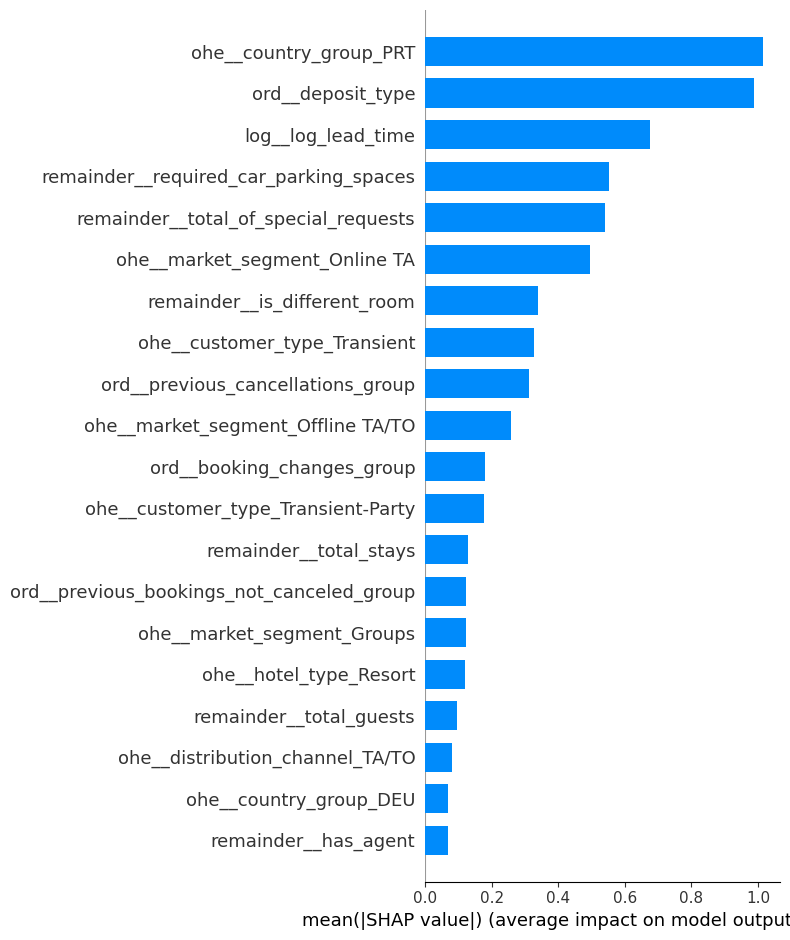

In [ ]:
shap.summary_plot(shap_values, X_dev_trans, feature_names=feature_names, plot_type="bar")

Dựa vào biểu đồ trên, cho thấy mức độ ảnh hưởng trung bình của các đặc trưng ohe_country_group_PRT, ohe_deposit_type, log_log_lead_time,remainder_required_car_parking_spaces, remainder_total_of_special_requests, ohe_market_segment_online_TAkhá mạnh đến đầu ra mô hình. Ngoài ra nhóm có ảnh hưởng trung bình remainder_is_different_room,ohe_customer_type_Transient,ord_previous_cancellations_group,ohe_market_segment_Offline TA/TO và các đặc trưng còn lại có giá trị SHAP trung bình < 0.2 cho thấy mức độ đóng góp cho quyết định mô hình thấp hơn.
- Vì vậy kết quả dữ đoán trên có thể do mô hình bị ảnh hưởng nhiều bởi các đặc trưng như lead_time mặc định là khách đặt sát ngày là không hủy nên dẫn đến việc bỏ sót các trường hợp hủy thực tế. Ngoài ra đặc trưng về quốc tịch của khách cũng quá khác biệt so với phần còn lại như quốc gia PRT ảnh hưởng nhiều hơn DEU.


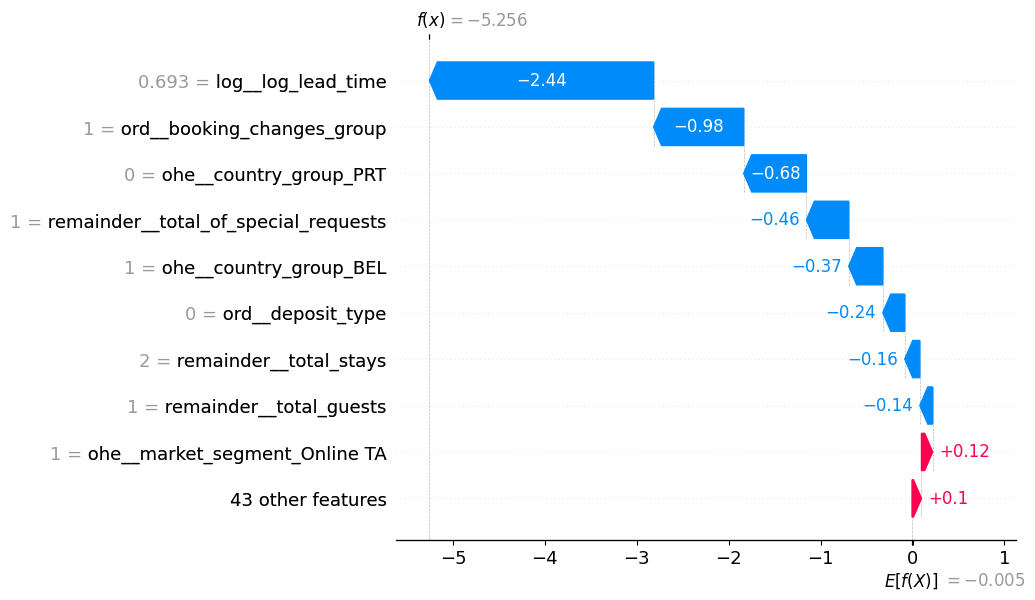

In [ ]:
# Đơn đầu tiên
shap.plots.waterfall(shap_values[0])

* Nhận xét:
  
  Giá trị dự đoán trung bình của mô hình (giá trị kỳ vọng) là -0.005.
  
  Giá trị dự đoán cho trường hợp đầu tiên này là -5.256 (bé hơn giá trị kỳ vọng)--> khả năng cao trường hợp này mô hình dự đoán là không hủy (nhãn 0).
  
  Các đặc trưng làm giảm khả năng hủy là:
    - log_log_lead_time=0.693, shap=-2.44 --> thời gian đặt sát ngày thì giảm khả năng hủy.
    - ord_booking_changes_group=1, shap=-0.98 --> thay đổi thông tin có thể làm giảm khả năng hủy.
    - ohe_country_group_PRT=0, shap=-0.68 --> khách không đên từ quốc gia PRT sẽ làm giảm khả năng hủy.
     - remainder_total_of_special_requests=1, shap=-0.46 --> có yêu cầu đặc biệt sẽ làm giảm khả năng hủy vì có chuẩn bị, tìm hiểu trước.
    - ohe_country_group_BEL=1, shap=-0.37 --> khách đến từ quốc gia BEL thì khả năng hủy sẽ giảm.
    - ord_deposit_type=0, shap=-0.24 --> khách dùng loại không đặt cọc góp phần làm giảm khả năng hủy.
    - remainder_total_stays=2,shap=-0.16 --> khách lưu trú nhiều đêm hơn thì sẽ làm giảm khả năng hủy.
    - remainder_total_guests=1, shap=-0.14 --> số lượng khách thường là 1 sẽ làm giảm khả năng hủy.

  Các đặc trưng làm tăng khả năng hủy là:
    - ohe_market_segment_Online TA=1, shap=+0.12 --> đặt qua đại lý online làm tăng khả năng hủy, có thể do chính sách ưu đãi ở đại lý.

  Tuy nhiên yếu tố quan trọng làm giảm khả năng hủy phòng mạnh nhất là lead_time (log(lead_time)=0.693≈2 ngày) --> đặt sát ngày thì thường không hủy trong trường hợp này.

- Mô hình đã có thể giải thích tốt với các đặc trưng quan trọng và phản ánh được đúng logic.

# Lưu mô hình

In [ ]:
import joblib

Model_path = "/content/drive/MyDrive/DS102 - Machine Learning/Hotel/models/"

joblib.dump(best_rand.named_steps["model"], Model_path + "XGBoost_model.pkl")

['/content/drive/MyDrive/DS102 - Machine Learning/Hotel/models/XGBoost_model.pkl']